# Significance Testing

## PM Experiment

We use an $F$-test, so we first need to estimate the effective degrees of freedom.

### PM ensemble
6 start years ($M=6$) each with 40 ensemble members ($N=40$)

$\text{DOF}=M\times N-1=6\times 40 -1=239$

### Control run
300 years, equivalent to 300 samples per month, but we need to account for autocorrelation using [Bretherton et al. (1999)](https://doi-org.ezproxy.princeton.edu/10.1175/1520-0442(1999)012<1990:TENOSD>2.0.CO;2).

> Different ‘‘realizations’’ would now correspond to independent sets of $T$ observations.

> Following the approach of section 4b of looking at the distribution of the sample covariance between two unrelated time series, one can derive an analogous formula for the ESS appropriate for significance tests of the correlation between two times series $X_i$ and $Y_i$ with different autocorrelation sequences $\rho_\tau^X$ and $\rho_\tau^Y$:
$$
T_{XY}^*=\frac{T}{\sum\limits_{\tau=-(T-1)}^{(T-1)} (1-|\tau|/T)\rho_\tau^X\rho_\tau^Y}
$$

For the control run, we are accounting for autocorrelation so the equation from Bretherton et al. (1999) becomes the following:
$$
T_{XX}^*=\frac{T}{\sum\limits_{\tau=-(T-1)}^{(T-1)} (1-|\tau|/T)\left(\rho_\tau^X\right)^2}
$$

In [74]:
import xarray as xr
import numpy as np
import scipy.signal as signal
import scipy.stats as stats
import esmtools.stats as esmstats

import matplotlib.pyplot as plt

In [10]:
def open_metric(var, reg, metric, timescale='monthly', ens_type=''):
    
    writedir = '/home/bbuchovecky/storage/so_predict_derived/'
    
    if metric == 'clim':
        subdir = 'CTRL/'+var.upper()+'/'
        filename = var.lower()+'_ts_'+reg+'_'+metric+'.nc'
    
    if metric == 'anom' or metric == 'mean' or (metric == 'var' and timescale == 'monthly'):
        subdir = 'CTRL/'+var.upper()+'/'
        filename = var.lower()+'_ts_'+reg+'_'+timescale+'_'+metric+'.nc'
    
    if metric.lower() == 'ppp':
        subdir = 'PPP/'+var.upper()+'/'
        if ens_type != '':
            ens_type += '_'
        filename = var.lower()+'_ts_'+reg+'_'+timescale+'_'+ens_type+'ppp.nc'
        
    return xr.open_dataset(writedir+subdir+filename)

def get_plotting_labels():
    with open('/home/bbuchovecky/storage/so_predict_derived/plotting_dicts.pkl','rb') as handle:
        plotting_dicts = pkl.load(handle)
    
    reg_names = plotting_dicts['reg_names']
    var_abbrv_names = plotting_dicts['var_abbrv_names']
    abbrv_month_names = plotting_dicts['abbrv_month_names']
    month_letters = plotting_dicts['month_letters']
    
    return reg_names, var_abbrv_names, abbrv_month_names, month_letters

#### Figuring out how to compute the autocorrelation

In [51]:
test1 = open_metric('sst', 'so', 'anom')['SouthernOcean']
test2 = open_metric('sst', 'so', 'anom')['SouthernOcean']

In [81]:
t1 = test1.values
t2 = test2.values

mode = 'full'
method = 'auto'
size = len(test1)

lags = signal.correlation_lags(len(t1), len(t2), mode=mode)
        
## normalize with the following:
xcov1 = signal.correlate(t1 - np.mean(t1), t2 - np.mean(t2), mode=mode, method=method)   
xcorr1 = xcov1 / (t1.std() * t2.std() * size)

xcov2 = signal.correlate(t1, t2, mode=mode, method=method)   
xcorr2 = xcov2 / (t1.std() * t2.std() * size)

In [71]:
esmcorr = np.empty(3598*2+1)

for x in range(len(esmcorr)):
    esmcorr[x] = esmstats.corr(test1,test2,dim='month',lead=-3598+x).values
    if x%200 == 0:
        print(x)

0
200
400
600
800
1000
1200
1400
1600
1800
2000
2200
2400
2600
2800
3000
3200
3400
3600
3800
4000
4200
4400
4600
4800
5000
5200
5400
5600
5800
6000
6200
6400
6600
6800
7000


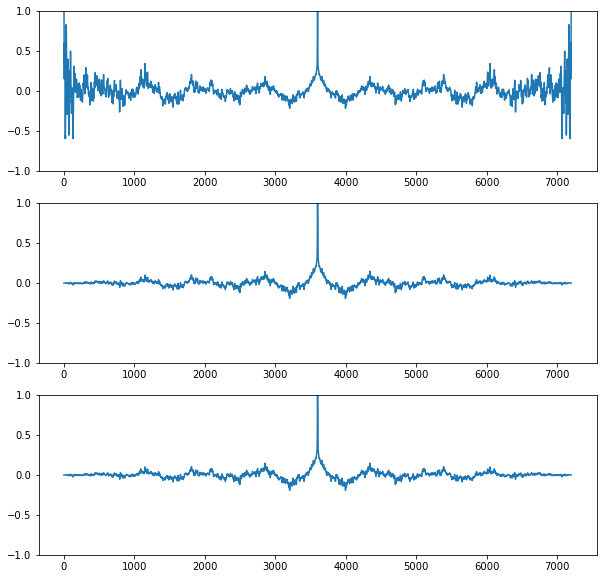

In [89]:
fig,ax = plt.subplots(3,figsize=(10,10))

ax[0].plot(esmcorr)
ax[1].plot(xcorr1)
ax[2].plot(xcorr2)

for a in ax:
    a.set_ylim(-1,1)

### Computing the $F$ test critical values at different confidence levels

`scipy.stats.f.ppf(q, dfn, dfd)` is the inverse CDF (i.e., the quantile function) which we can use to generate the critical values for an $F$ test with `dfn` as the DOF in the numerator and `dfd` as the DOF in the denominator.

[scipy.stats.rv_continuous.ppf](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.rv_continuous.ppf.html#scipy.stats.rv_continuous.ppf) - Percent point function (inverse of cdf) at $q$ of the given RV.

In [100]:
## critical value at the 95% confidence level
stats.f.ppf(q=0.05, dfn=39, dfd=3)

0.35148547185567414

### Performing the $F$ test
[F Statistic/F value](https://www.statisticshowto.com/probability-and-statistics/f-statistic-value-test/#WhatisF)

[F Test](https://www.statisticshowto.com/probability-and-statistics/hypothesis-testing/f-test/)

In [116]:
s1 = np.random.randn(100)
s2 = np.random.randn(100)

In [117]:
stats.f_oneway(s1,s2)

F_onewayResult(statistic=0.4974027806955424, pvalue=0.48147240130178726)

In [121]:
s1.var() / s2.var()

0.8594776047540551

## Correlation

$$
T_{XY}^*=\frac{T}{\sum\limits_{\tau=-(T-1)}^{(T-1)} (1-|\tau|/T)\rho_\tau^X\rho_\tau^Y}
$$

In [170]:
def compute_eff_DOF(ts1, ts2):
    assert len(ts1) == len(ts2) == 300
    T = 300
    cumsum = 0
    
    ## compute demoninator
    for tau in range(-299,299+1):
        coeff = 1 - (abs(tau)/T)
        
        if tau < 0:
            rho_1 = stats.pearsonr(ts1[:tau],ts1[-tau:])
            rho_2 = stats.pearsonr(ts2[:tau],ts2[-tau:])
        if tau == 0:
            rho_1 = stats.pearsonr(ts1,ts1)
            rho_2 = stats.pearsonr(ts2,ts2)
        if tau > 0:
            rho_1 = stats.pearsonr(ts1[tau:],ts1[:-tau])
            rho_2 = stats.pearsonr(ts2[tau:],ts2[:-tau])
            
        cumsum += coeff * rho_1 * rho_2
    
    return T / cumsum

In [169]:
ts = np.arange(10)
print(ts)
print()
for tau in range(-9,9+1):
    
    if tau < 0:
        print('ts1['+str()+':'+str(tau)+']     ts2['+str(-tau)+':'+str('')+']')
        print('ts1 = ' + str(ts[:tau]))
        print('ts2 = ' + str(ts[-tau:]))
        print()
        
    if tau == 0:
        print('ts1     ts2')
        print('ts1 = ' + str(ts))
        print('ts2 = ' + str(ts))
        print()
        
    if tau > 0:
        print('ts1['+str(tau)+':'+str()+']     ts2['+str()+':'+str(-tau)+']')
        print('ts1 = ' + str(ts[tau:]))
        print('ts2 = ' + str(ts[:-tau]))
        print()

[0 1 2 3 4 5 6 7 8 9]

ts1[:-9]     ts2[9:]
ts1 = [0]
ts2 = [9]

ts1[:-8]     ts2[8:]
ts1 = [0 1]
ts2 = [8 9]

ts1[:-7]     ts2[7:]
ts1 = [0 1 2]
ts2 = [7 8 9]

ts1[:-6]     ts2[6:]
ts1 = [0 1 2 3]
ts2 = [6 7 8 9]

ts1[:-5]     ts2[5:]
ts1 = [0 1 2 3 4]
ts2 = [5 6 7 8 9]

ts1[:-4]     ts2[4:]
ts1 = [0 1 2 3 4 5]
ts2 = [4 5 6 7 8 9]

ts1[:-3]     ts2[3:]
ts1 = [0 1 2 3 4 5 6]
ts2 = [3 4 5 6 7 8 9]

ts1[:-2]     ts2[2:]
ts1 = [0 1 2 3 4 5 6 7]
ts2 = [2 3 4 5 6 7 8 9]

ts1[:-1]     ts2[1:]
ts1 = [0 1 2 3 4 5 6 7 8]
ts2 = [1 2 3 4 5 6 7 8 9]

ts1     ts2
ts1 = [0 1 2 3 4 5 6 7 8 9]
ts2 = [0 1 2 3 4 5 6 7 8 9]

ts1[1:]     ts2[:-1]
ts1 = [1 2 3 4 5 6 7 8 9]
ts2 = [0 1 2 3 4 5 6 7 8]

ts1[2:]     ts2[:-2]
ts1 = [2 3 4 5 6 7 8 9]
ts2 = [0 1 2 3 4 5 6 7]

ts1[3:]     ts2[:-3]
ts1 = [3 4 5 6 7 8 9]
ts2 = [0 1 2 3 4 5 6]

ts1[4:]     ts2[:-4]
ts1 = [4 5 6 7 8 9]
ts2 = [0 1 2 3 4 5]

ts1[5:]     ts2[:-5]
ts1 = [5 6 7 8 9]
ts2 = [0 1 2 3 4]

ts1[6:]     ts2[:-6]
ts1 = [6 7 8 9]
ts2 = [0 1 2 3]

ts

In [ ]:
def compute_f_stat(predictor, predictand):
    ## convert DataArray to NumPy array
    predictor = predictor.values
    predictand = predictand.values
    
    ## rows are different init months, cols are different lags
    eff_dof = np.zeros((abs(maxlag)+1, 12))
    
    for (it,init) in enumerate(range(0,12)):
        for (ig,lag) in enumerate(range(0,12)):
            
            tmp_predictand = predictand[init:N:12]
            tmp_predictor = predictor[init:N:12]
            